# Sentiment analysis of the spread of hate in tweets using RNN

## 1. Understanding the Problem Statement

Twitter is one of the biggest and most popular social networks with around 300 million users, 40% of which are active on the platform multiple times per day. Hence, it’s understandable the need to monitor the sentiment of the users, especially if it can help stop the spread of hateful and damaging massages. 

Sentiment Analysis on tweets extracted from Twitter will be execute on this project. The tool used for this porpouse is Recurrent Neural Networks (RNNs). The main goal is the implementation and evaluation of a RNN model with different layers as LSTM, GRU, and one attempt of adding a CNN layer to compare its performances. Pretrained word vectors from GloVe model trained with tweets are also loaded in our model in an Embeddign layer, which will also help to improve the model. 

## 2. About the dataset

The data used was found on Kaggle: 

https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?utm_medium=social&utm_campaign=kaggle-dataset-share&utm_source=twitter&select=train.csv

The dataset used to build and evaluate the model contains 31963 rows and three columns: 
    
    id - ID assigned to each tweet
    label - 1 if the tweeter is considered hateful and 0 non-hateful
    tweet - string containing tweet’s text.
    
Additionally, in this source we can find a diferent dataset with 17197 unlabeled tweets which we will try to label with our final and improved model.


## 3. Import Libraries

In [1]:
# Import modules

import numpy
import numpy as np
from numpy.random import seed

import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import inspect
import tensorflow
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

## 4. Read and Inspect the Data

In [2]:
tweets= pd.read_csv('train.csv')
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (tweets.label == 1).sum(),
    (tweets.label == 0).sum()
))

Hatred labeled: 2242
Non-hatred labeled: 29720


## 5. Text Cleaning and Preprocessing

In [4]:
#Removing hashtags and creating hashtags column
hashtags = tweets['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
tweets.loc[:, 'hashtags'] = hashtags['hashtag']
tweets['hashtags'].fillna('', inplace=True)


/Users/albertodelgadolopez/anaconda3/lib/python3.8/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


In [5]:
# remove URL's and @users
tweets['clean_tweet'] = tweets['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))

tweets['clean_tweet'] = tweets['tweet'].apply(lambda x: re.sub('@[a-zA-Z0-9_]+', '', x))

In [6]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'

tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
tweets['clean_tweet'] = tweets['clean_tweet'].str.lower()

# remove numbers
tweets['clean_tweet'] = tweets['clean_tweet'].str.replace("[0-9]", " ")

# remove whitespaces
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda x:' '.join(x.split()))


<ipython-input-6-700705d69de6>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['clean_tweet'] = tweets['clean_tweet'].str.replace("[0-9]", " ")


In [7]:
#Lemmatizing tweets

#!pip3 install -U spacy
#!python3 -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize text
def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

In [8]:
tweets['clean_tweet'] = lemmatization(tweets['clean_tweet'])

In [9]:
#Removing whatever non-character rest that could remain in the tweets

tweets['clean_tweet2'] = tweets.clean_tweet.str.replace('[^a-zA-Z]', ' ')
#tweets['lwords'] = tweets['clean_tweet2'].apply(lambda x: x.split())

<ipython-input-9-36208e7d8220>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets['clean_tweet2'] = tweets.clean_tweet.str.replace('[^a-zA-Z]', ' ')


In [10]:
tweets.sample(10)

,id,label,tweet,hashtags,clean_tweet,clean_tweet2
31401,31402,0,ð«ðthis kid #helpme #wheredidhegoishede...,helpme wheredidhegoishedead vm,ð«ðthis kid helpme wheredidhegoishedead vm,this kid helpme wheredidhegoishedead vm
21795,21796,0,@user = bush league today,,bush league today,bush league today
21926,21927,0,@user it's official! we're launching our webs...,,it be official we be launch our website on tue...,it be official we be launch our website on tue...
17408,17409,1,uk 2016 expressed as a photo #euref #brexit,euref brexit,uk express as a photo euref brexit,uk express as a photo euref brexit
7570,7571,0,#model i love u take with u all the time in ...,model,model I love u take with u all the time in urð...,model I love u take with u all the time in ur ...
4248,4249,0,@user just settling down for the final stage o...,,just settle down for the final stage of the cr...,just settle down for the final stage of the cr...
12871,12872,0,come and work for this lovely pub! :-),,come and work for this lovely pub,come and work for this lovely pub
16943,16944,0,only 4?! that's disgusting. there were dozens ...,,only that be disgusting . there be dozen invol...,only that be disgusting there be dozen invol...
14719,14720,0,do whatever makes you happy. #pamperingmyself...,pamperingmyself saloon hairdo,do whatever make you happy . pamperingmyself l...,do whatever make you happy pamperingmyself l...
13610,13611,0,have my lover stop being angry at me visit us....,lover friend astrologer love,have my lover stop be angry at I visit we .. g...,have my lover stop be angry at I visit we g...


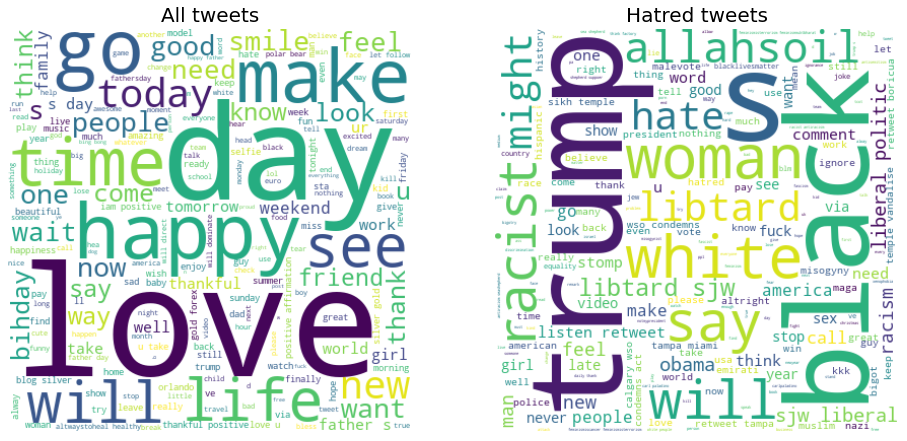

In [11]:
#Most used words

stopwords = STOPWORDS.add('amp')

all_words = ' '.join(tweets.clean_tweet2.values)
hatred_words = ' '.join(tweets[tweets.label == 1].clean_tweet2.values)

plt.figure(figsize=(16, 8))

cloud1 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(all_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('All tweets', size=20)

cloud2 = WordCloud(width=400, height=400, background_color='white', stopwords=stopwords).generate(hatred_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Hatred tweets', size=20)
plt.show()

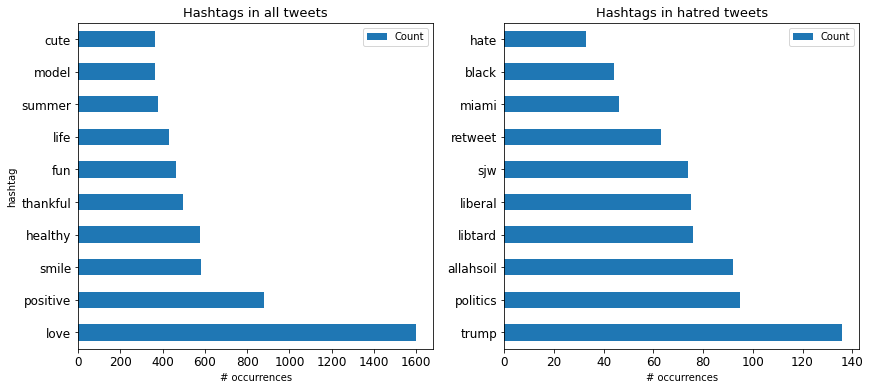

In [12]:
#Most used hashtags

all_hashtags = FreqDist(list(' '.join(tweets.hashtags.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(tweets[tweets.label==1].hashtags.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

In [13]:
#Splitting the data in 80% train and 20% test

X_train, X_test, Y_train, Y_test = train_test_split(list(tweets.clean_tweet2), list(tweets.label),test_size=0.2, random_state=42)

## 6. Pretrained word vectors

### Global Vectors for Word Representation (GloVe)
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm developed by researchers at Stanford University aiming to generate word embeddings (vector representations for words). Its training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space which have the potential for encoding some form of meaning. It's essentially a log-bilinear model with a weighted least-squares objective.

#### Pre-trained GloVe word vectors used:

Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB download): https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [14]:
#Crating glove dictionary from downloaded pre-trained GloVe word vectors

def get_glove_vectors(filename="glove.twitter.27B.200d.txt"):
    # Get all word vectors from pre-trained model
    glove_vector_dict = {}
    with open(filename) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove_vector_dict[word] = np.asarray(coefs, dtype='float32')
    
    return glove_vector_dict

In [15]:
glove_dict=get_glove_vectors()

In [16]:
#Encoding vocabulary from training tweets

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
print(tokenizer.word_index)

{'be': 1, 'the': 2, 'to': 3, 'i': 4, 'a': 5, 'you': 6, 'and': 7, 'in': 8, 'for': 9, 'of': 10, 'not': 11, 'my': 12, 'it': 13, 'love': 14, 'do': 15, 'have': 16, 'day': 17, 'this': 18, 'on': 19, 'with': 20, 'that': 21, 'we': 22, 'all': 23, 'so': 24, 'get': 25, 'happy': 26, 's': 27, 'your': 28, 'at': 29, 'can': 30, 'amp': 31, 'go': 32, 'will': 33, 'good': 34, 'just': 35, 'when': 36, 'life': 37, 'time': 38, 'make': 39, 'u': 40, 'like': 41, 'what': 42, 'they': 43, 'but': 44, 'today': 45, 'from': 46, 'see': 47, 'up': 48, 'new': 49, 'now': 50, 'positive': 51, 'thankful': 52, 'out': 53, 'as': 54, 'father': 55, 'bihday': 56, 'people': 57, 'he': 58, 'smile': 59, 'how': 60, 'our': 61, 'about': 62, 'by': 63, 'one': 64, 'take': 65, 'no': 66, 'work': 67, 'want': 68, 'look': 69, 'come': 70, 'more': 71, 'friend': 72, 'if': 73, 'wait': 74, 'feel': 75, 'who': 76, 'need': 77, 'weekend': 78, 'healthy': 79, 'fun': 80, 'thank': 81, 'family': 82, 'week': 83, 'an': 84, 'girl': 85, 'there': 86, 'summer': 87, 't

In [18]:
#Number of words in our vocabulary

len(tokenizer.word_index)

30352

In [19]:
# Filter GLoVE vectors to our specific vocabulary

def filter_glove(vocabulary_dict, glove_dict, wordvec_dim):
    # Create a matrix to store the vectors
    embedding_matrix = np.zeros((len(vocabulary_dict) + 1, wordvec_dim))
    for word,i in vocabulary_dict.items():
        embedding_vector = glove_dict.get(word)
        if embedding_vector is not None:
            # words not found in the glove_dict will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [20]:
glove_matrix = filter_glove(vocabulary_dict=tokenizer.word_index,glove_dict=glove_dict,wordvec_dim=200)
print(glove_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.72794002  0.41955999 -0.28589001 ... -0.1469     -0.035087
  -0.022335  ]
 [ 0.49349999  0.35698     0.66068    ...  0.17705999 -0.53694999
  -0.29699001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [21]:
len(glove_matrix)

30353

## 7. Prepare the (X, Y) variables to fit the model

In [22]:
# Change texts into sequence of indexes
train_numeric = tokenizer.texts_to_sequences(X_train)
test_numeric = tokenizer.texts_to_sequences(X_test)

In [23]:
for i in range(3):
    print('\n',train_numeric[i],"\n\n",len(train_numeric[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [146, 4, 138, 1, 155, 1232, 9, 2, 794, 99, 99, 58, 1, 5] 

 14 

 ['because', 'I', 've', 'be', 'pay', 'attention', 'for', 'the', 'past', 'year', 'year', 'he', 'be', 'a'] 

 14 

********************** 0

 [11035, 1522, 29, 11036, 7227, 54, 354, 10, 2, 11037, 80, 2886, 4659, 2655] 

 14 

 ['raft', 'building', 'at', 'salford', 'quay', 'as', 'pa', 'of', 'the', 'gmw', 'fun', 'outdoors', 'badge', 'guide'] 

 14 

********************** 1

 [96, 7228, 96, 160, 1744, 11038, 11039, 11040, 527, 11041] 

 10 

 ['friday', 'gdegblog', 'friday', 'selfie', 'beard', 'gayguy', 'gaymen', 'gaystyle', 'lifestyle', 'fullness'] 

 10 

********************** 2


In [24]:
# Largest tweet

largest=0
for i in range(len(train_numeric)):
    largest=max(largest,len(train_numeric[i]))
for i in range(len(test_numeric)):
    largest=max(largest,len(test_numeric[i]))
    
print(largest)

34


In [25]:
# Pad the sequences
train_pad = pad_sequences(train_numeric, largest)
test_pad = pad_sequences(test_numeric, largest)
Y_train = numpy.array(Y_train)
Y_test = numpy.array(Y_test)

In [26]:
for i in range(3):
    print('\n',train_pad[i],"\n\n",len(train_pad[i]),"\n\n", X_train[i].split(),"\n\n",len(X_train[i].split()),'\n')
    print("**********************",i)


 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  146    4  138    1  155 1232    9    2
  794   99   99   58    1    5] 

 34 

 ['because', 'I', 've', 'be', 'pay', 'attention', 'for', 'the', 'past', 'year', 'year', 'he', 'be', 'a'] 

 14 

********************** 0

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 11035  1522    29 11036
  7227    54   354    10     2 11037    80  2886  4659  2655] 

 34 

 ['raft', 'building', 'at', 'salford', 'quay', 'as', 'pa', 'of', 'the', 'gmw', 'fun', 'outdoors', 'badge', 'guide'] 

 14 

********************** 1

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
    96  7228    96   160  1744 11038 11039 11040   527 11041] 

 34 

 ['friday', 'gdegblog', 'friday', 'selfie', 'beard', 'gayguy', 'gaymen', 'gaystyle', 'lifesty

## 8. Creating the model using keras

In the model different layers are applied such as Dropout, LSTM and Gru to account for the issues that might arise when implementing a RNN model. 

- Both LSTM and GRU layers are used to account for "Exploding Gradient" and "Vanishing Gradient" issues. 

- Dropout is used "to prevent over-fitting" by ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random.

- Also, pre-trained weights are used in this model by passing Glove to the Embedding layer. This improves much more the performance since it gives information to the model about the probability for most of the words to appear in the tweets.

### Basic RNN model with LSTM, GRU and Dropout layers

In [74]:
# Instantiate the model class
model_basic = Sequential()

# Add the layers
model_basic.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    input_length=largest, name="Embedding"))
model_basic.add(Dense(200,activation='relu', name="Dense1"))
model_basic.add(Dropout(rate=0.25))
model_basic.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM"))
model_basic.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU"))
model_basic.add(Dense(64, name="Dense2"))
model_basic.add(Dropout(rate=0.25))
model_basic.add(Dense(32, name="Dense3"))
model_basic.add(Dense(1, activation='sigmoid', name="Output"))

model_basic.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
history = model_basic.fit(train_pad,Y_train, epochs=20, validation_data=(test_pad,Y_test), batch_size=batch)

Epoch 1/20
800/800 [==============================] - 31s 35ms/step - loss: 0.2254 - accuracy: 0.9336 - val_loss: 0.1740 - val_accuracy: 0.9390
Epoch 2/20
800/800 [==============================] - 27s 34ms/step - loss: 0.1610 - accuracy: 0.9468 - val_loss: 0.1454 - val_accuracy: 0.9518
Epoch 3/20
800/800 [==============================] - 24s 30ms/step - loss: 0.1332 - accuracy: 0.9552 - val_loss: 0.1548 - val_accuracy: 0.9443
Epoch 4/20
800/800 [==============================] - 25s 31ms/step - loss: 0.1132 - accuracy: 0.9608 - val_loss: 0.1311 - val_accuracy: 0.9545
Epoch 5/20
800/800 [==============================] - 29s 36ms/step - loss: 0.1015 - accuracy: 0.9641 - val_loss: 0.1290 - val_accuracy: 0.9565
Epoch 6/20
800/800 [==============================] - 24s 30ms/step - loss: 0.0900 - accuracy: 0.9686 - val_loss: 0.1274 - val_accuracy: 0.9606
Epoch 7/20
800/800 [==============================] - 23s 29ms/step - loss: 0.0813 - accuracy: 0.9700 - val_loss: 0.1312 - val_accuracy:

In [75]:
model_basic.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 34, 200)           6070600   
                                                                 
 Dense1 (Dense)              (None, 34, 200)           40200     
                                                                 
 dropout_72 (Dropout)        (None, 34, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 34, 64)            67840     
                                                                 
 GRU (GRU)                   (None, 64)                24960     
                                                                 
 Dense2 (Dense)              (None, 64)                4160      
                                                                 
 dropout_73 (Dropout)        (None, 64)              

In [2]:
print('Loss:',round(np.mean(history.history['val_loss']),4),'Accuracy:',round(100*np.mean(history.history['val_accuracy']),2),'%')

Loss: 0.1631 Accuracy: 95.51 %


### Adding Glove pretrained word vectors to the model

In [77]:
# Instantiate the model class
model_GloVe = Sequential()

# Add the layers
model_GloVe.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model_GloVe.add(Dense(200,activation='relu', name="Dense1"))
model_GloVe.add(Dropout(rate=0.25))
model_GloVe.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM"))
model_GloVe.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU"))
model_GloVe.add(Dense(64, name="Dense2"))
model_GloVe.add(Dropout(rate=0.25))
model_GloVe.add(Dense(32, name="Dense3"))
model_GloVe.add(Dense(1, activation='sigmoid', name="Output"))

model_GloVe.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
history = model_GloVe.fit(train_pad,Y_train, epochs=20, validation_data=(test_pad,Y_test), batch_size=batch)

Epoch 1/20
800/800 [==============================] - 29s 32ms/step - loss: 0.1652 - accuracy: 0.9422 - val_loss: 0.1370 - val_accuracy: 0.9514
Epoch 2/20
800/800 [==============================] - 27s 33ms/step - loss: 0.1234 - accuracy: 0.9558 - val_loss: 0.1185 - val_accuracy: 0.9559
Epoch 3/20
800/800 [==============================] - 27s 34ms/step - loss: 0.1065 - accuracy: 0.9610 - val_loss: 0.1220 - val_accuracy: 0.9585
Epoch 4/20
800/800 [==============================] - 29s 36ms/step - loss: 0.0926 - accuracy: 0.9663 - val_loss: 0.1125 - val_accuracy: 0.9584
Epoch 5/20
800/800 [==============================] - 26s 33ms/step - loss: 0.0817 - accuracy: 0.9706 - val_loss: 0.1138 - val_accuracy: 0.9595
Epoch 6/20
800/800 [==============================] - 25s 31ms/step - loss: 0.0743 - accuracy: 0.9742 - val_loss: 0.1139 - val_accuracy: 0.9596
Epoch 7/20
800/800 [==============================] - 25s 32ms/step - loss: 0.0658 - accuracy: 0.9766 - val_loss: 0.1327 - val_accuracy:

In [1]:
print('Loss:',round(np.mean(history.history['val_loss']),4),'Accuracy:',round(100*np.mean(history.history['val_accuracy']),2),'%')

Loss: 0.1492 Accuracy: 95.92 %


## 9. Evaluating the model with different parameters and CNN layer

List of paramaters which are optimized:

- Batch size of the model - it pertains to the amount of training samples to consider at a time for updating the network weights
- The dropout rate - fraction of the input units to drop, used to add noise to the model
- Trainable argument of the Embedding layer - false for keeping the weights fixed and True if the weights will be updated during the training
- Adding Conv1D layer from Convolutional Neural Network - creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs

### Parameters tuning 

In [29]:
# epochs: determine how many weight updates will be done on the model -> We choose 20
# batch_size: size of the data on each step -> Also increases the speed of the training, depends on the computer capacity
# drop: rate of the dropout layer, used to add noise to the model 

model_list = []
for drop in [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    for batch in [4, 8, 16, 32, 64, 80, 100]:
        seed(321)
        tensorflow.random.set_seed(123)
    
        model = Sequential()

        # Add the layers
        model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                            output_dim=200,
                            trainable=False,
                            embeddings_initializer=Constant(glove_matrix),
                            input_length=largest, name="Embedding"))
        model.add(Dense(200,activation='relu', name="Dense1"))
        model.add(Dropout(drop))
        model.add(LSTM(64, return_sequences=True, dropout=drop, name="LSTM"))
        model.add(GRU(64, return_sequences=False, dropout=drop, name="GRU"))
        model.add(Dense(64, name="Dense2"))
        model.add(Dropout(drop))
        model.add(Dense(32, name="Dense3"))
        model.add(Dense(1, activation='sigmoid', name="Output"))

        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        print(drop,batch)
        
        history = model.fit(train_pad,Y_train, epochs=20, validation_data=(test_pad,Y_test), batch_size=batch)
        model_list.append([drop, batch, np.mean(history.history['val_loss']),np.mean(history.history['val_accuracy'])])

0 4
Epoch 1/20
6393/6393 [==============================] - 122s 19ms/step - loss: 0.1517 - accuracy: 0.9457 - val_loss: 0.1365 - val_accuracy: 0.9489
Epoch 2/20
6393/6393 [==============================] - 114s 18ms/step - loss: 0.1114 - accuracy: 0.9594 - val_loss: 0.1242 - val_accuracy: 0.9551
Epoch 3/20
6393/6393 [==============================] - 113s 18ms/step - loss: 0.0893 - accuracy: 0.9675 - val_loss: 0.1246 - val_accuracy: 0.9554
Epoch 4/20
6393/6393 [==============================] - 114s 18ms/step - loss: 0.0698 - accuracy: 0.9746 - val_loss: 0.1197 - val_accuracy: 0.9587
Epoch 5/20
6393/6393 [==============================] - 135s 21ms/step - loss: 0.0535 - accuracy: 0.9811 - val_loss: 0.1253 - val_accuracy: 0.9551
Epoch 6/20
6393/6393 [==============================] - 133s 21ms/step - loss: 0.0410 - accuracy: 0.9853 - val_loss: 0.1619 - val_accuracy: 0.9531
Epoch 7/20
6393/6393 [==============================] - 134s 21ms/step - loss: 0.0309 - accuracy: 0.9896 - val_los

Epoch 17/20
1599/1599 [==============================] - 38s 24ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.2655 - val_accuracy: 0.9548
Epoch 18/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.2686 - val_accuracy: 0.9564
Epoch 19/20
1599/1599 [==============================] - 38s 24ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.2724 - val_accuracy: 0.9581
Epoch 20/20
1599/1599 [==============================] - 38s 24ms/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.2697 - val_accuracy: 0.9540
0 32
Epoch 1/20
800/800 [==============================] - 27s 30ms/step - loss: 0.1567 - accuracy: 0.9431 - val_loss: 0.1380 - val_accuracy: 0.9506
Epoch 2/20
800/800 [==============================] - 23s 29ms/step - loss: 0.1140 - accuracy: 0.9589 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 3/20
800/800 [==============================] - 24s 30ms/step - loss: 0.0928 - accuracy: 0.9661 - val_loss: 0.124

Epoch 9/20
800/800 [==============================] - 28s 35ms/step - loss: 0.0267 - accuracy: 0.9902 - val_loss: 0.1917 - val_accuracy: 0.9581
Epoch 10/20
800/800 [==============================] - 26s 33ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.1624 - val_accuracy: 0.9582
Epoch 11/20
800/800 [==============================] - 27s 33ms/step - loss: 0.0179 - accuracy: 0.9936 - val_loss: 0.2154 - val_accuracy: 0.9600
Epoch 12/20
800/800 [==============================] - 27s 34ms/step - loss: 0.0170 - accuracy: 0.9937 - val_loss: 0.2630 - val_accuracy: 0.9570
Epoch 13/20
800/800 [==============================] - 27s 34ms/step - loss: 0.0135 - accuracy: 0.9947 - val_loss: 0.2278 - val_accuracy: 0.9579
Epoch 14/20
800/800 [==============================] - 27s 34ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.2257 - val_accuracy: 0.9570
Epoch 15/20
800/800 [==============================] - 27s 34ms/step - loss: 0.0154 - accuracy: 0.9946 - val_loss: 0.2786 - val_acc

3197/3197 [==============================] - 73s 23ms/step - loss: 0.0692 - accuracy: 0.9748 - val_loss: 0.1204 - val_accuracy: 0.9570
Epoch 6/20
3197/3197 [==============================] - 72s 22ms/step - loss: 0.0587 - accuracy: 0.9786 - val_loss: 0.1287 - val_accuracy: 0.9579
Epoch 7/20
3197/3197 [==============================] - 72s 23ms/step - loss: 0.0485 - accuracy: 0.9827 - val_loss: 0.1631 - val_accuracy: 0.9600
Epoch 8/20
3197/3197 [==============================] - 72s 23ms/step - loss: 0.0420 - accuracy: 0.9842 - val_loss: 0.1575 - val_accuracy: 0.9557
Epoch 9/20
3197/3197 [==============================] - 72s 23ms/step - loss: 0.0369 - accuracy: 0.9864 - val_loss: 0.1643 - val_accuracy: 0.9611
Epoch 10/20
3197/3197 [==============================] - 71s 22ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.1424 - val_accuracy: 0.9596
Epoch 11/20
3197/3197 [==============================] - 72s 22ms/step - loss: 0.0293 - accuracy: 0.9893 - val_loss: 0.1745 - val_accu

3197/3197 [==============================] - 62s 20ms/step - loss: 0.0346 - accuracy: 0.9881 - val_loss: 0.1382 - val_accuracy: 0.9590
Epoch 18/20
3197/3197 [==============================] - 62s 19ms/step - loss: 0.0338 - accuracy: 0.9884 - val_loss: 0.1867 - val_accuracy: 0.9590
Epoch 19/20
3197/3197 [==============================] - 63s 20ms/step - loss: 0.0313 - accuracy: 0.9884 - val_loss: 0.1663 - val_accuracy: 0.9606
Epoch 20/20
3197/3197 [==============================] - 62s 19ms/step - loss: 0.0333 - accuracy: 0.9881 - val_loss: 0.1594 - val_accuracy: 0.9625
0.2 16
Epoch 1/20
1599/1599 [==============================] - 40s 23ms/step - loss: 0.1621 - accuracy: 0.9433 - val_loss: 0.1301 - val_accuracy: 0.9524
Epoch 2/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.1208 - accuracy: 0.9552 - val_loss: 0.1215 - val_accuracy: 0.9556
Epoch 3/20
1599/1599 [==============================] - 36s 23ms/step - loss: 0.1057 - accuracy: 0.9615 - val_loss: 0.1316 - 

Epoch 9/20
1599/1599 [==============================] - 38s 24ms/step - loss: 0.0718 - accuracy: 0.9727 - val_loss: 0.1243 - val_accuracy: 0.9584
Epoch 10/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.0687 - accuracy: 0.9756 - val_loss: 0.1238 - val_accuracy: 0.9575
Epoch 11/20
1599/1599 [==============================] - 36s 23ms/step - loss: 0.0651 - accuracy: 0.9772 - val_loss: 0.1323 - val_accuracy: 0.9568
Epoch 12/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.0611 - accuracy: 0.9780 - val_loss: 0.1365 - val_accuracy: 0.9600
Epoch 13/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.0584 - accuracy: 0.9787 - val_loss: 0.1348 - val_accuracy: 0.9607
Epoch 14/20
1599/1599 [==============================] - 36s 23ms/step - loss: 0.0568 - accuracy: 0.9798 - val_loss: 0.1257 - val_accuracy: 0.9593
Epoch 15/20
1599/1599 [==============================] - 37s 23ms/step - loss: 0.0546 - accuracy: 0.9796 - val_loss: 0.

0.4 32
Epoch 1/20
800/800 [==============================] - 26s 29ms/step - loss: 0.1775 - accuracy: 0.9365 - val_loss: 0.1442 - val_accuracy: 0.9463
Epoch 2/20
800/800 [==============================] - 22s 28ms/step - loss: 0.1406 - accuracy: 0.9490 - val_loss: 0.1257 - val_accuracy: 0.9507
Epoch 3/20
800/800 [==============================] - 23s 28ms/step - loss: 0.1265 - accuracy: 0.9540 - val_loss: 0.1221 - val_accuracy: 0.9542
Epoch 4/20
800/800 [==============================] - 22s 28ms/step - loss: 0.1152 - accuracy: 0.9578 - val_loss: 0.1186 - val_accuracy: 0.9543
Epoch 5/20
800/800 [==============================] - 23s 29ms/step - loss: 0.1099 - accuracy: 0.9603 - val_loss: 0.1135 - val_accuracy: 0.9560
Epoch 6/20
800/800 [==============================] - 23s 29ms/step - loss: 0.1035 - accuracy: 0.9614 - val_loss: 0.1126 - val_accuracy: 0.9578
Epoch 7/20
800/800 [==============================] - 24s 30ms/step - loss: 0.0973 - accuracy: 0.9646 - val_loss: 0.1172 - val_ac

Epoch 13/20
800/800 [==============================] - 23s 28ms/step - loss: 0.1007 - accuracy: 0.9639 - val_loss: 0.1286 - val_accuracy: 0.9571
Epoch 14/20
800/800 [==============================] - 22s 28ms/step - loss: 0.0960 - accuracy: 0.9640 - val_loss: 0.1349 - val_accuracy: 0.9567
Epoch 15/20
800/800 [==============================] - 22s 28ms/step - loss: 0.0959 - accuracy: 0.9644 - val_loss: 0.1235 - val_accuracy: 0.9589
Epoch 16/20
800/800 [==============================] - 23s 28ms/step - loss: 0.0965 - accuracy: 0.9636 - val_loss: 0.1136 - val_accuracy: 0.9579
Epoch 17/20
800/800 [==============================] - 23s 28ms/step - loss: 0.0931 - accuracy: 0.9649 - val_loss: 0.1178 - val_accuracy: 0.9578
Epoch 18/20
800/800 [==============================] - 22s 28ms/step - loss: 0.0905 - accuracy: 0.9657 - val_loss: 0.1162 - val_accuracy: 0.9575
Epoch 19/20
800/800 [==============================] - 23s 28ms/step - loss: 0.0910 - accuracy: 0.9674 - val_loss: 0.1216 - val_ac

In [54]:
df_models = pd.DataFrame(model_list, columns = ['dropout', 'batch', 'loss', 'accuracy'])

In [31]:
df_models.sort_values('loss').head()

,dropout,batch,loss,accuracy
27,0.4,16,0.125028,0.957586
32,0.5,16,0.125138,0.955099
28,0.4,32,0.125800,0.957805
26,0.4,8,0.126107,0.956906
33,0.5,32,0.126128,0.954919


In [34]:
df_models1.sort_values('loss').head()

,dropout,batch,loss,accuracy
10,0.4,80,0.123857,0.957743
12,0.5,80,0.124694,0.955357
11,0.4,100,0.125141,0.957109
13,0.5,100,0.127638,0.955537
8,0.3,80,0.129467,0.958666


In [55]:
df_models.sort_values('accuracy',ascending=False).head()

,dropout,batch,loss,accuracy
6,0.2,16,0.144033,0.959737
8,0.3,16,0.127214,0.958455
7,0.2,32,0.151834,0.958408
9,0.3,32,0.131202,0.958251
11,0.4,32,0.125800,0.957805


In [36]:
df_models1.sort_values('accuracy',ascending=False).head()

,dropout,batch,loss,accuracy
6,0.2,80,0.143366,0.959260
4,0.1,80,0.168336,0.959002
8,0.3,80,0.129467,0.958666
5,0.1,100,0.163648,0.958423
7,0.2,100,0.140396,0.958064


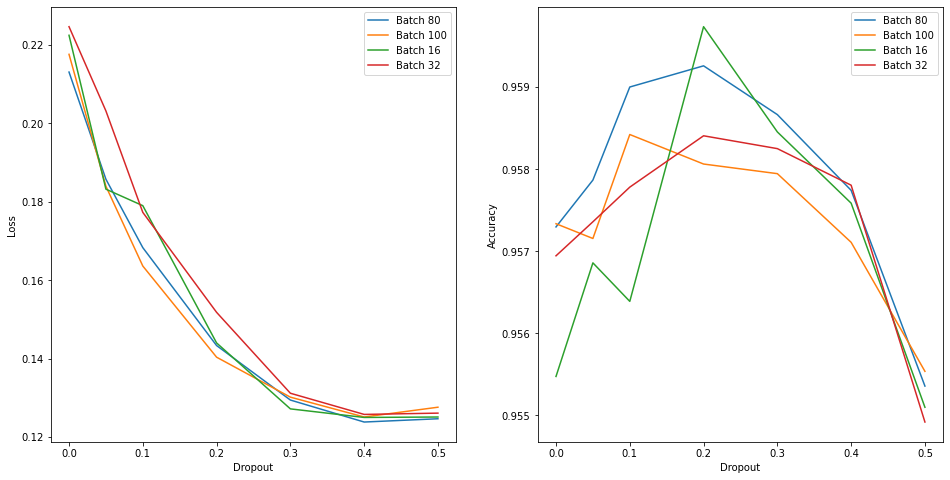

In [79]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(df_models1[df_models1['batch']==80]['dropout'],df_models1[df_models1['batch']==80]['loss'])
plt.plot(df_models1[df_models1['batch']==100]['dropout'],df_models1[df_models1['batch']==100]['loss'])
plt.plot(df_models[df_models['batch']==16]['dropout'],df_models[df_models['batch']==16]['loss'])
plt.plot(df_models[df_models['batch']==32]['dropout'],df_models[df_models['batch']==32]['loss'])
plt.xlabel("Dropout")
plt.ylabel('Loss')
plt.legend(['Batch 80', 'Batch 100', 'Batch 16', 'Batch 32'])

plt.subplot(1, 2, 2)
plt.plot(df_models1[df_models1['batch']==80]['dropout'],df_models1[df_models1['batch']==80]['accuracy'])
plt.plot(df_models1[df_models1['batch']==100]['dropout'],df_models1[df_models1['batch']==100]['accuracy'])
plt.plot(df_models[df_models['batch']==16]['dropout'],df_models[df_models['batch']==16]['accuracy'])
plt.plot(df_models[df_models['batch']==32]['dropout'],df_models[df_models['batch']==32]['accuracy'])
plt.xlabel("Dropout")
plt.ylabel('Accuracy')
plt.legend(['Batch 80', 'Batch 100', 'Batch 16', 'Batch 32'])

The highest accuracy is achieved with drop=0.2 and batch_size=16, but since the loss could be still improved by increasing the drop rate, the chosen paramaters will be drop=0.3 and batch_size=80 (this also increases the speed of the model trainings).

### Chosen parameters model

In [45]:
# Instantiate the model class
model = Sequential()

# Add the layers
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model.add(Dense(200,activation='relu', name="Dense1"))
model.add(Dropout(rate=0.3))
model.add(LSTM(64, return_sequences=True, dropout=0.3, name="LSTM"))
model.add(GRU(64, return_sequences=False, dropout=0.3, name="GRU"))
model.add(Dense(64, name="Dense2"))
model.add(Dropout(rate=0.3))
model.add(Dense(32, name="Dense3"))
model.add(Dense(1, activation='sigmoid', name="Output"))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(train_pad,Y_train,
                       epochs=20,
                       validation_data=(test_pad,Y_test),
                       batch_size=80)

Epoch 1/20
320/320 [==============================] - 17s 44ms/step - loss: 0.1804 - accuracy: 0.9357 - val_loss: 0.1390 - val_accuracy: 0.9460
Epoch 2/20
320/320 [==============================] - 15s 45ms/step - loss: 0.1367 - accuracy: 0.9504 - val_loss: 0.1303 - val_accuracy: 0.9482
Epoch 3/20
320/320 [==============================] - 17s 52ms/step - loss: 0.1192 - accuracy: 0.9566 - val_loss: 0.1248 - val_accuracy: 0.9529
Epoch 4/20
320/320 [==============================] - 15s 46ms/step - loss: 0.1092 - accuracy: 0.9601 - val_loss: 0.1150 - val_accuracy: 0.9589
Epoch 5/20
320/320 [==============================] - 15s 46ms/step - loss: 0.1004 - accuracy: 0.9645 - val_loss: 0.1242 - val_accuracy: 0.9565
Epoch 6/20
320/320 [==============================] - 14s 45ms/step - loss: 0.0917 - accuracy: 0.9670 - val_loss: 0.1284 - val_accuracy: 0.9573
Epoch 7/20
320/320 [==============================] - 15s 46ms/step - loss: 0.0893 - accuracy: 0.9680 - val_loss: 0.1145 - val_accuracy:

In [47]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'test_'+metric])

(0.0, 0.18736788146197797)

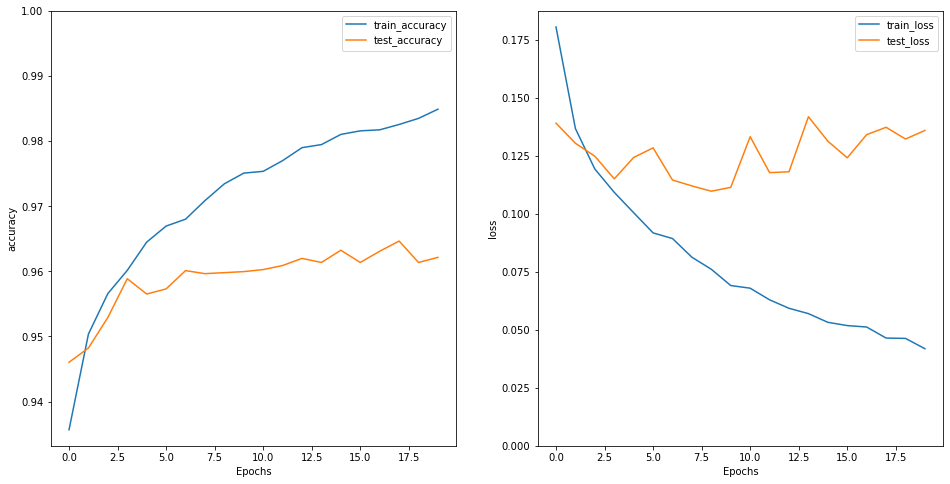

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [49]:
#Evaluate the model:
score_train, acc_train = model.evaluate(train_pad, Y_train)
score_test, acc_test = model.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train,4),'Acc:',round(acc_train*100,2),'% ')
print('Test:\n Loss:',round(score_test,4),'Acc:',round(acc_test*100,2),'% ')

200/200 [==============================] - 2s 8ms/step - loss: 0.1359 - accuracy: 0.9621
Train:
 Loss: 0.0191 Acc: 99.42 % 
Test:
 Loss: 0.1359 Acc: 96.21 % 


### Trainable Embedding layer

In [91]:
# Instantiate the model class
model_trainable = Sequential()

# Add the layers
model_trainable.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=True,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
model_trainable.add(Dense(200,activation='relu', name="Dense1"))
model_trainable.add(Dropout(rate=0.3))
model_trainable.add(LSTM(64, return_sequences=True, dropout=0.3, name="LSTM"))
model_trainable.add(GRU(64, return_sequences=False, dropout=0.3, name="GRU"))
model_trainable.add(Dense(64, name="Dense2"))
model_trainable.add(Dropout(rate=0.3))
model_trainable.add(Dense(32, name="Dense3"))
model_trainable.add(Dense(1, activation='sigmoid', name="Output"))

model_trainable.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_trainable.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 34, 200)           6070600   
                                                                 
 Dense1 (Dense)              (None, 34, 200)           40200     
                                                                 
 dropout_78 (Dropout)        (None, 34, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 34, 64)            67840     
                                                                 
 GRU (GRU)                   (None, 64)                24960     
                                                                 
 Dense2 (Dense)              (None, 64)                4160      
                                                                 
 dropout_79 (Dropout)        (None, 64)              

In [92]:
history = model_trainable.fit(train_pad,Y_train,
                              epochs=20,
                              validation_data=(test_pad,Y_test),
                              batch_size=80)

Epoch 1/20
320/320 [==============================] - 34s 98ms/step - loss: 0.1674 - accuracy: 0.9416 - val_loss: 0.1159 - val_accuracy: 0.9557
Epoch 2/20
320/320 [==============================] - 30s 95ms/step - loss: 0.0891 - accuracy: 0.9670 - val_loss: 0.1084 - val_accuracy: 0.9614
Epoch 3/20
320/320 [==============================] - 31s 97ms/step - loss: 0.0467 - accuracy: 0.9829 - val_loss: 0.1348 - val_accuracy: 0.9634
Epoch 4/20
320/320 [==============================] - 31s 97ms/step - loss: 0.0268 - accuracy: 0.9902 - val_loss: 0.1475 - val_accuracy: 0.9585
Epoch 5/20
320/320 [==============================] - 31s 97ms/step - loss: 0.0176 - accuracy: 0.9938 - val_loss: 0.1813 - val_accuracy: 0.9595
Epoch 6/20
320/320 [==============================] - 31s 97ms/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.1863 - val_accuracy: 0.9618
Epoch 7/20
320/320 [==============================] - 31s 96ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.2067 - val_accuracy:

(0.0, 0.48653558499645444)

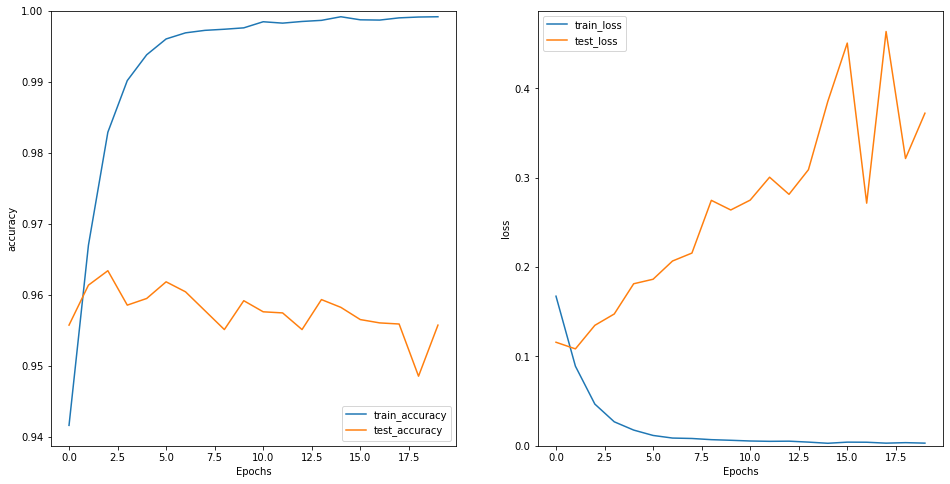

In [93]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [5]:
#Evaluate the model:
score_train_trainable, acc_train_trainable = model_trainable.evaluate(train_pad, Y_train)
score_test_trainable, acc_test_trainable = model_trainable.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train_trainable,4),'Acc:',round(acc_train_trainable*100,2),'% ')
print('Test:\n Loss:',round(score_test_trainable,4),'Acc:',round(acc_test_trainable*100,2),'% ')

Train:
 Loss: 0.0009  Acc: 99.97 %
Test:
 Loss: 0.3721  Acc: 95.57 %


It improved the performance for the training dataset, but it got worse for the test one. This seems logic since training more parameters we got to make the model more specific,i.e., we trained it to make better predictions on tweets more similar to the ones we used for training it. It makes the model less general, and worse predicting new and more different tweets. It is something similar to what happens when reducing the drop_out rate.

Therefore, we stablish the trainable argument = False.

### Convolution layer

The mix of convolution and max pooling layers with RNN cells has been used recently and achieved state of the art results in NLP problems. In short:

- The Conv1D has filters that determines the output dimension, kernel size which is the window size for convolution and padding which determines if the input should be padded (add zeros around the matrix) or not. 

- The MaxPooling1D contains the parameter pool size that determines the window to look for the max value. 

In [102]:
# Instantiate the model class
modelcnn = Sequential()

# Add the layers
modelcnn.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=200,
                    trainable=False,
                    embeddings_initializer=Constant(glove_matrix),
                    input_length=largest, name="Embedding"))
modelcnn.add(Conv1D(filters=32, kernel_size=3, padding='same'))
modelcnn.add(MaxPooling1D(pool_size=2))
modelcnn.add(Dense(200,activation='relu', name="Dense1"))
modelcnn.add(Dropout(rate=0.3))
modelcnn.add(LSTM(64, return_sequences=True, dropout=0.3, name="LSTM"))
modelcnn.add(GRU(64, return_sequences=False, dropout=0.3, name="GRU"))
modelcnn.add(Dense(64, name="Dense2"))
modelcnn.add(Dropout(rate=0.3))
modelcnn.add(Dense(32, name="Dense3"))
modelcnn.add(Dense(1, activation='sigmoid', name="Output"))

modelcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelcnn.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 34, 200)           6070600   
                                                                 
 conv1d (Conv1D)             (None, 34, 32)            19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17, 32)           0         
 )                                                               
                                                                 
 Dense1 (Dense)              (None, 17, 200)           6600      
                                                                 
 dropout_80 (Dropout)        (None, 17, 200)           0         
                                                                 
 LSTM (LSTM)                 (None, 17, 64)            67840     
                                                     

In [103]:
history = modelcnn.fit(train_pad,Y_train,
                       epochs=20,
                       validation_data=(test_pad,Y_test),
                       batch_size=80)

Epoch 1/20
320/320 [==============================] - 13s 31ms/step - loss: 0.1751 - accuracy: 0.9389 - val_loss: 0.1383 - val_accuracy: 0.9493
Epoch 2/20
320/320 [==============================] - 12s 39ms/step - loss: 0.1340 - accuracy: 0.9516 - val_loss: 0.1271 - val_accuracy: 0.9510
Epoch 3/20
320/320 [==============================] - 13s 42ms/step - loss: 0.1150 - accuracy: 0.9588 - val_loss: 0.1467 - val_accuracy: 0.9524
Epoch 4/20
320/320 [==============================] - 11s 34ms/step - loss: 0.0982 - accuracy: 0.9642 - val_loss: 0.1216 - val_accuracy: 0.9546
Epoch 5/20
320/320 [==============================] - 10s 31ms/step - loss: 0.0856 - accuracy: 0.9701 - val_loss: 0.1322 - val_accuracy: 0.9548
Epoch 6/20
320/320 [==============================] - 10s 32ms/step - loss: 0.0738 - accuracy: 0.9739 - val_loss: 0.1358 - val_accuracy: 0.9557
Epoch 7/20
320/320 [==============================] - 11s 35ms/step - loss: 0.0618 - accuracy: 0.9784 - val_loss: 0.1416 - val_accuracy:

(0.0, 0.32780736684799194)

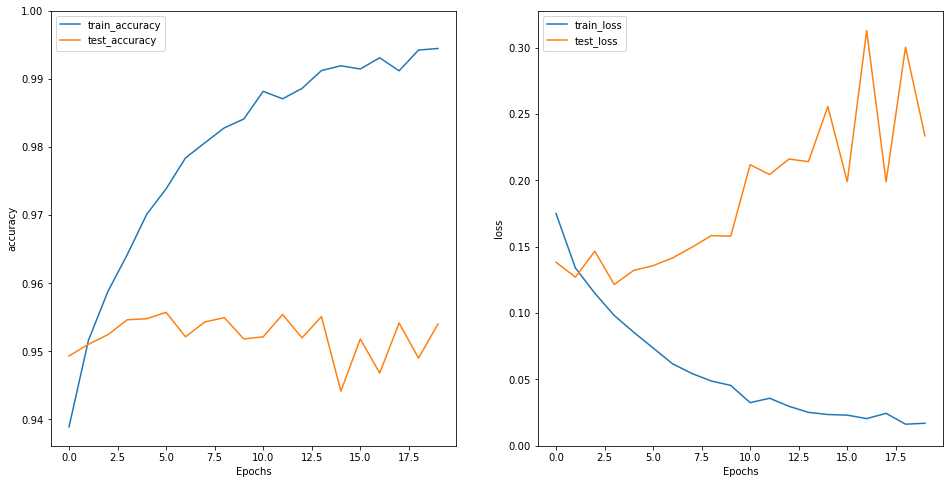

In [104]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [8]:
#Evaluate the model:
score_train_cnn, acc_train_cnn = modelcnn.evaluate(train_pad, Y_train)
score_test_cnn, acc_test_cnn = modelcnn.evaluate(test_pad, Y_test)
print('Train:\n Loss:',round(score_train_cnn,4),'% ','Acc:',round(acc_train_cnn*100,2),'% ')
print('Test:\n Loss:',round(score_test_cnn,4),'% ','Acc:',round(acc_test_cnn*100,2),'% ')

Train:
 Loss: 0.0066  Acc: 99.74 % 
Test:
 Loss: 0.2336  Acc: 95.4 % 


In a similar way like the trainable embedding layer, the convolution layers improved the performance of the model for the training dataset, but it got worse for the test one. The test loss increases with the trainings and the accuracy seems to lightly decrease and it becomes more 'unstable'.

Therefore, we decide to reject the idea of adding CNN layers to the model.

## 10. Evaluating the predictions for the final model

In [51]:
#Results of the previous evaluation of the final model:
print('Train:\n Loss:',round(score_train,4),'Acc:',round(acc_train*100,2),'% ')
print('Test:\n Loss:',round(score_test,4),'Acc:',round(acc_test*100,2),'% ')

Train:
 Loss: 0.0191 Acc: 99.42 % 
Test:
 Loss: 0.1359 Acc: 96.21 % 


In [52]:
#Predictions on the training data (apparently not 100% acc)

pred_train=model.predict(train_pad)
print(pred_train)

[[7.4230343e-01]
 [3.2529288e-06]
 [4.6751236e-07]
 ...
 [9.9943972e-01]
 [1.0228804e-01]
 [1.3825181e-01]]


In [53]:
for i in range(len(pred_train)):
    if pred_train[i]<0.5:
        pred_train[i]=0
    else:
        pred_train[i]=1

In [54]:
print("TRAIN:\n\nHatred labeled: {}\nNon-hatred labeled: {}\nTotal number of tweets: {}".format(
    (Y_train == 1).sum(),
    (Y_train == 0).sum(),
    len(Y_train)
))
print()
print("PREDICTED TRAIN:\n\nHatred labeled: {}\nNon-hatred labeled: {}\nTotal number of tweets: {}".format(
    (pred_train == 1).sum(),
    (pred_train == 0).sum(),
    len(pred_train)
))
cf_matrix = confusion_matrix(Y_train, pred_train)
print('\nConfusion matrix:\n\n',cf_matrix)

TRAIN:

Hatred labeled: 1786
Non-hatred labeled: 23783
Total number of tweets: 25569

PREDICTED TRAIN:

Hatred labeled: 1693
Non-hatred labeled: 23876
Total number of tweets: 25569

Confusion matrix:

 [[23755    28]
 [  121  1665]]


In [55]:
#Predictions on the test data

pred_test=model.predict(test_pad)

In [56]:
for i in range(len(pred_test)):
    if pred_test[i]<0.5:
        pred_test[i]=0
    else:
        pred_test[i]=1

In [57]:
print("TEST:\n\nHatred labeled: {}\nNon-hatred labeled: {}\nTotal number of tweets: {}".format(
    (Y_test == 1).sum(),
    (Y_test == 0).sum(),
    len(Y_test)
))
print()
print("PREDICTED TRAIN:\n\nHatred labeled: {}\nNon-hatred labeled: {}\nTotal number of tweets: {}".format(
    (pred_test == 1).sum(),
    (pred_test == 0).sum(),
    len(pred_test)
))
cf_matrix = confusion_matrix(Y_test, pred_test)
print('\nConfusion matrix:\n\n',cf_matrix)

TEST:

Hatred labeled: 456
Non-hatred labeled: 5937
Total number of tweets: 6393

PREDICTED TRAIN:

Hatred labeled: 360
Non-hatred labeled: 6033
Total number of tweets: 6393

Confusion matrix:

 [[5864   73]
 [ 169  287]]


## 11. Making predictions on new data

In [58]:
# Cleaning tweets
new_data= pd.read_csv('test.csv')
hashtags = new_data['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
new_data.loc[:, 'hashtags'] = hashtags['hashtag']
new_data['hashtags'].fillna('', inplace=True)
new_data['clean_tweet'] = new_data['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
new_data['clean_tweet'] = new_data['tweet'].apply(lambda x: re.sub('@[a-zA-Z0-9_]+', '', x))
new_data['clean_tweet'] = new_data['clean_tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))
new_data['clean_tweet'] = new_data['clean_tweet'].str.lower()
new_data['clean_tweet'] = new_data['clean_tweet'].str.replace("[0-9]", " ")
new_data['clean_tweet'] = new_data['clean_tweet'].apply(lambda x:' '.join(x.split()))
new_data['clean_tweet'] = lemmatization(new_data['clean_tweet'])
new_data['clean_tweet'] = new_data.clean_tweet.str.replace('[^a-zA-Z]', ' ')
new_data.head(8)

/Users/albertodelgadolopez/anaconda3/lib/python3.8/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
<ipython-input-58-5c6c2aa300d9>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  new_data['clean_tweet'] = new_data['clean_tweet'].str.replace("[0-9]", " ")
<ipython-input-58-5c6c2aa300d9>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  new_data['clean_tweet'] = new_data.clean_tweet.str.replace('[^a-zA-Z]', ' ')


,id,tweet,hashtags,clean_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,studiolife aislife require passion dedication ...
1,31964,@user #white #supremacists want everyone to s...,white supremacists birds movie,white supremacist want everyone to see the new...
2,31965,safe ways to heal your #acne!! #altwaystohe...,acne altwaystoheal healthy healing,safe way to heal your acne altwaystoheal healt...
3,31966,is the hp and the cursed child book up for res...,harrypotter pottermore favorite,be the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",bihday nephew,rd bihday to my amazing hilarious nephew eli...
5,31968,choose to be :) #momtips,momtips,choose to be momtip
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,smokeyeyes tired lonely sof grunge,something inside I die eye ness ...
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,finished tattoo inked ink loveit thanks aleeee,finishedtattooinkedinkloveit ...


In [59]:
newdata_numeric = tokenizer.texts_to_sequences(new_data.clean_tweet)
newdata_pad = pad_sequences(newdata_numeric, largest)
pred_nd=model.predict(newdata_pad)

In [60]:
new_data['label_predicted']=0

for i in range(len(pred_nd)):
    if pred_nd[i]<0.5:
        new_data['label_predicted'][i]=0
    else:
        new_data['label_predicted'][i]=1

<ipython-input-60-15c174003067>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['label_predicted'][i]=0
<ipython-input-60-15c174003067>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['label_predicted'][i]=1


In [128]:
pd.set_option('display.max_colwidth', None)
new_data[new_data.label_predicted == 1][['tweet','label_predicted']].sample(10)

,tweet,label_predicted
799,@user i can't wait till you are impeached traitor. you deserve to be in jail for so many things. #impeachtrump #traitor,1
7209,@user is not an #opinion. racism is #degrading people based on race to justify #discrimination or open #violence againstâ¦,1
309,"@user @user we hear your ,#bigotry ,#homophobia, #sexual assaults, #womanizing, #treason , #lies you hearâ¦",1
1009,there is lot of #racialhate in america that provides these two lunatics suppo to perpetuate hate. #dumptrump,1
13024,women nude anal girls nude sex act,1
3977,this year in stupid (2016) #regressiveleft #lefty #maga #feminism #endrapeculture #migrantcrisis #corruption,1
13861,book - enduring conviction: fred korematsu &amp; his quest for #justice #humanrights htâ¦,1
12408,.@user caught with the hand in the cookie jar. he should just man up and admit he is racist,1
12927,"#wordstwittermademehate ""alt-right"". let's just call it what it is, folks.",1
487,somebody tell @user #thepeople didn't chose @user #hispeople choose #trump ~ big difference!,1


In [123]:
new_data[['tweet','label_predicted']].sample(10)

,tweet,label_predicted
12842,"@user idk what's worse.. that joey didn't get to raise the cup, i don't get to see his beard anymore, or that sid won htâ¦",0
15181,that awesome feeling when the client says they have no comments and really like it. #designlife #designthinking #designmatters,0
2196,â£â£â£best dayâ£â£â£ #summer #relax #i #2016 #life #friends #girl #instasize #instadailyâ¦,0
7514,@user i had no idea she was transphobic and misogynist! sad. her mom talks a lot about in the #judo world.,1
9241,"oh noes, @user ist leer. #moment",0
9557,@user #tgif #ff to my #gamer #squad! @user @user @user @user @user @user,0
9359,my hea goes out to all of those affected by this tragedy,0
14048,"@user our mind has a way of painting a worse picture when we are sad, anxious or alone.",0
9637,#payday bull up: you will dominate your bull and you will direct it whatever you want it to do. when you s,0
6034,missing something i never had. #love,0


In [109]:
print("Hatred labeled: {}\nNon-hatred labeled: {}\nTotal number of tweets: {}".format(
    (new_data.label_predicted == 1).sum(),
    (new_data.label_predicted == 0).sum(),
    len(new_data)
))

Hatred labeled: 969
Non-hatred labeled: 16228
Total number of tweets: 17197


The interesting thing of these particular sets of tweets is that during the collection of them the trending topics were the #TrumpImpeachment and the #BlackLivesMatter movement. The model classify correctly lots of tweets but probably is failing on others because it was trained that words like 'Trump' and 'race', 'black', 'women', etc. usually belong to hate tweets, even when it is not exactly the case. Lots of tweets are not saying anything hateful perse, but the topic and context of the sentence, from the political and social point of view, is creating polarization of the society even if the tweet was using respectuful words and manners. 

## 11. Conclusion

The best model performance was shown by the RNN model with LSTM, GRU, Dropout and GloVe Embedding layers.

The parameters that showed best results where the batch_size=80 and Drop_out=0.3.

Training the Embedding layer parameters or adding CNN layers to the model did improve the results for the train data (they made it more specific to our tweets), but did not for the test data, we need a more general model which  predicts more diverse tweets. That is why the final model was the one chosen without Training Embedding layer and without CNN layers.

So, a final Accuracy of 96.21% and a Loss value of 0.1359 in the test data was achieved with the final model. This is a pretty good result that we can check by looking at the predictions made on the new_data set of unlabeled tweets which were labeled by the model.